# Introduction

---

## 1. Introducing gated convolutions
In the first experiment with a basic convolutional neural network (CNN), we observed that the model produced various types of visual artifacts, from discolouration to patterns that resembled the shape of the patch, and we hypothesized that it arose from convolutions operating on the hole values (set to 0, by default).

Following the work of [Liu et al. (2018)](https://arxiv.org/pdf/1804.07723.pdf)and [Yu et. al (2018)](https://arxiv.org/abs/1806.03589), we implement gated convolutions as a simple yet flexible way to ensure that "invalid" pixels are not used in the image generation process in a learnable fashion.

As a means of providing more information to the model, we also provide the mask as an input channel.

---

## 2. Modified U-Net

### 2.1 Choice of U-Net architecture

In our earlier experiment with a CNN, we noted that skip connections would likely help with faster training. We also noted that maintaining activation maps of equal dimensions at all layers was computationally expensive. To that end, a model design with skip connections, a downsampling then upsampling operation with the ability to reconstruct pixel-level details would be ideal. The U-Net architecture proposed by [Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597) suits this.

### 2.2 Introducing residual skips

As argued by [He et al. (2015)](https://arxiv.org/abs/1512.03385), residual skips allow for the practical training of deeper neural networks with higher representational power, as the improved gradient flow alleviates the vanishing gradient problem and residual skips tend toward the identity function, rather than the zero function. 

To increase the receptive field of each masked pixel in the output, we need to deepen the network, and so introduce residual skips as a practical matter. 

### 2.3 Downsampling by convolutions, rather than pooling

In the original paper, the U-Net model was designed for image segmentation and uses max-pooling for downsampling. Owing to the translation and (somewhat) rotation invariance of max pooling, this operator works well for segmentation. But the loss of localization information likely leads to lossy downsampling in the application to image generation for inpainting, so instead, we carry out downsampling by convolutions with larger strides.

So, we use a U-Net like architecture, with the added difference of residual skips at every block to improve gradient flow, as well as downsampling using convolutions, rather than pooling to avoid lossy downsampling (since our goal is to reconstruct the image).

### 2.4. Upsampling by convolutions and pixel shuffling

There is [evidence](https://distill.pub/2016/deconv-checkerboard/) to suggest that the transposed convolution operation as a manner of learnable upsampling tends to generate checkboard-like artefacts, due to overlapping points in the application of the convolution filter at the low-resolution feature maps. 

An alternative, thus, is to use nearest-neighbour interpolation paired with convolutions to upsample images. However, [Shi et al. (2017)](https://arxiv.org/ftp/arxiv/papers/1609/1609.07009.pdf) argue that carrying out upsampling by what they call "pixel shuffling" has higher representational power for the same computational complexity. The operation they propose works by using convolutions to generate *n x r<sup>2</sup> x h x w* feature maps from an input with *n* feature maps, and then "shuffling" these feature maps together to get an output of *n x (hr) x (wr)*. The intuition behind its greater representational power given the same time complexity, is that the convolutions are operating in the lower-resolution spce, rather than the higher-resolution space after upsampling - so more parameters can be learnt. 

---

## 3. A segmented loss function

In the basic CNN model, we trained the model with L1 loss, with the intuition that it would aid in high-accuracy pixel contruction. 

We observed empirically that the masked areas were much smaller than the overall image, and the error signal would probably not encourage the careful reconstruction of the masked regions. Considering that all that matters is the inpainted region, we can mask the output such that the loss is only with respect to the reconstructed area.


# Initialization

## Imports

In [1]:
# functional
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time

# visualization
import matplotlib.pyplot as plt

# images
from skimage import io
from skimage import transform

# metrics
import torchmetrics


/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import custom methods

In [2]:
import sys
sys.path.append("/home/e/e0425222/CS4243/")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import visualize_results, sample_batch

# Model

## Define model
Here, we define five main classes to encapsulate the logic:
 1. `GatedConv2d` 
 2. `GatedConv2dBlock`
 3. `Conv2dBlock`
 4. `Conv2dPixelShuffleUpsample`
 5. `GatedConvUNet` class that encapsulates the main model.

 

In [3]:
class GatedConv2d(nn.Module):

    """
    This class implements a gated convolution. It works by applying a convolution filter 
    to the input feature tensor, then using the sigmoid function to map each score to a 
    pixel validity weight. The weights are then multiplied to the activation map from a 
    separate convolution filter.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(GatedConv2d, self).__init__()
        self.image_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):

        mask = self.sigmoid(self.gate_conv(input_tensor))
        x = self.image_conv(input_tensor)
        x = torch.mul(x, mask) # apply mask

        return x


class GatedConv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    GatedConv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(GatedConv2dBlock, self).__init__()
        self.conv = GatedConv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = self.activation(x)

        return x


class Conv2dBlock(nn.Module):
    """
    This class encapsulates the following:
    Conv2d -> BN -> activation
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation = nn.ReLU, p = 0.2):
        super(Conv2dBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.activation = activation()
    
    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.bn(x)
        x = self.activation(x)

        return x


class GatedConv2dPixelShuffleUpsample(nn.Module):
    """
    This class encapsulates a convolution layer using GatedConv
    and PixelShuffling to upsample. Returns same number of channels, with
    output spatial dimensions scaled.
    """

    def __init__(self, in_channels, upscale_factor = 2):

        super(GatedConv2dPixelShuffleUpsample, self).__init__()
        self.conv = GatedConv2dBlock(in_channels, upscale_factor ** 2 * in_channels, kernel_size = 3, stride = 1, padding = 'same')
        self.upsample = nn.PixelShuffle(upscale_factor = upscale_factor)
    
    def forward(self, input_tensor):
        
        x = self.conv(input_tensor)
        return self.upsample(x)

class Conv2dPixelShuffleUpsample(nn.Module):
    """
    This class encapsulates a convolution layer using normal 2d convolutions
    and PixelShuffling to upsample. Returns same number of channels, with
    output spatial dimensions scaled.
    """

    def __init__(self, in_channels, upscale_factor = 2):

        super(Conv2dPixelShuffleUpsample, self).__init__()
        self.conv = Conv2dBlock(in_channels, upscale_factor ** 2 * in_channels, kernel_size = 3, stride = 1, padding = 'same')
        self.upsample = nn.PixelShuffle(upscale_factor = upscale_factor)
    
    def forward(self, input_tensor):
        
        x = self.conv(input_tensor)
        return self.upsample(x)

class GatedConvUNet(nn.Module):
    """
    This class encapsulates a UNet-like model with gated convolution blocks and residual skips.
    """
    
    def __init__(self, 
                 blocks_per_layer = 2,
                 in_channels = 4, 
                 hidden_channels = 32, 
                 kernel_size = 3, 
                 stride = 1, 
                 padding = 'same',
                 activation = nn.ReLU):

        super(GatedConvUNet, self).__init__()

        # ===== DOWNSAMPLING =====
        
        # first convolution
        self.first = GatedConv2dBlock(in_channels, hidden_channels, kernel_size, stride, padding, activation)

        # convolutions
        self.down_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        self.down_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])        

        self.down_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        
        # downsampling by convolution
        self.downtransform_1 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_2 = GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)
        self.downtransform_3 = GatedConv2dBlock(hidden_channels, 2 * hidden_channels, kernel_size = 4, stride = 2, padding = 1, activation = activation)

        # ===== MIDDLE =====
        
        self.middle = nn.ModuleList(
            [GatedConv2dBlock(2 * hidden_channels, 2 * hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])  
        

        # ===== UPSAMPLING =====
        # upsample and convolution, always doubling
        self.upsample_1 = GatedConv2dPixelShuffleUpsample(in_channels = 2 * hidden_channels, upscale_factor = 2)
        self.uptransform_1 = GatedConv2dBlock(3 * hidden_channels, hidden_channels, kernel_size, stride, padding, activation)
        
        self.upsample_2 = GatedConv2dPixelShuffleUpsample(in_channels = hidden_channels, upscale_factor = 2)
        self.uptransform_2 = GatedConv2dBlock(2 * hidden_channels, hidden_channels, kernel_size, stride, padding, activation)

        self.upsample_3 = GatedConv2dPixelShuffleUpsample(in_channels = hidden_channels, upscale_factor = 2)
        self.uptransform_3 = GatedConv2dBlock(2 * hidden_channels, hidden_channels, kernel_size, stride, padding, activation)

        # convolutions
        self.up_1 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_2 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])
        
        self.up_3 = nn.ModuleList(
            [GatedConv2dBlock(hidden_channels, hidden_channels, kernel_size, stride, padding, activation) 
             for i in range(blocks_per_layer)])

        # final scores
        self.final = nn.Conv2d(hidden_channels, 3, kernel_size, stride, padding)

    def forward(self, input_tensor):
        
        # ===== DOWNSAMPLING =====

        # first layer
        x1 = self.first(input_tensor)
        for l in self.down_1:
            x1 = x1 + l(x1) # residual skips
        
        # second layer 
        x2 = self.downtransform_1(x1)
        for l in self.down_2:
            x2 = x2 + l(x2)

        # third layer 
        x3 = self.downtransform_2(x2)
        for l in self.down_3:
            x3 = x3 + l(x3)

        # ===== BOTTOM ====
        x = self.downtransform_3(x3)
        for l in self.middle:
            x = x + l(x)

        # ===== UPSAMPLING =====

        # first layer
        x = self.upsample_1(x) # upsample
        x = torch.concat([x, x3], dim = 1) # concat in channel dimension (second)
        x = self.uptransform_1(x)
        for l in self.up_1:
            x = x + l(x)
        
        # second layer 
        x = self.upsample_2(x) # upsample
        x = torch.concat([x, x2], dim = 1) # concat in channel dimension (second)
        x = self.uptransform_2(x)
        for l in self.up_2:
            x = x + l(x)

        # third layer
        x = self.upsample_3(x) # upsample
        x = torch.concat([x, x1], dim = 1) # concat in channel dimension (second)
        x = self.uptransform_3(x)
        for l in self.up_3:
            x = x + l(x)

        # ===== FINAL =====
        x = self.final(x)
        return x 


    def summary(self, verbose = False):
        count = 0
        if verbose:
            print(self)

        for name, params in self.named_parameters():
            num_params = params.flatten().size()[0]
            count += num_params
            if verbose:
                print(f"\nlayer: {name}")
                print(f"number of params: {num_params}")
                print(f"params shape: {params.size()}")

        print(f"model has {count/1e6} million parameters")

## Initialize model
Note that there is a significant difference in the depth (and thus, number of parameters) in the model. There are equivalently 17 layers in this model, relative to the 10 in the original CNN model.

In [4]:
# model parameters
blocks_per_layer = 1
in_channels = 3
hidden_channels = 32
kernel_size = 3
stride = 1
padding = 'same'
activation = nn.PReLU

# create model
model = GatedConvUNet(blocks_per_layer,
                      in_channels, 
                      hidden_channels, 
                      kernel_size, 
                      stride, 
                      padding,
                      activation)
model.summary(verbose = False)


model has 0.893489 million parameters


## Save model

In [5]:
MODEL_FOLDER = "/home/e/e0425222/CS4243/model_weights/GatedConvPixelShuffleUNet"

In [6]:
# save path
MODEL_NAME = "GatedConvPixelShuffleUNet_3downup_1blocksperlayer_32hidden_relu"
SAVE_PATH = f"{MODEL_FOLDER}/{MODEL_NAME}"

# save
torch.save(model.state_dict(), SAVE_PATH)

# sanity check
loaded = GatedConvUNet(blocks_per_layer,
                       in_channels, 
                       hidden_channels, 
                       kernel_size, 
                       stride, 
                       padding,
                       activation)

loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.summary()
del loaded

model has 0.893489 million parameters


# Training Details
For training, we define all details here, and wrap it into two main dictionaries, `training_params` and `metrics`.

## Custom loss function

In [7]:
def mask_segmented_loss(output, target, mask):
    """
    This is a custom functional loss function that considers where the mask is, and
    applies the loss function seperately. 
    """
    
    LOSS = nn.functional.l1_loss


    def weighted_sum():
        MASKED_WEIGHT = 10
        UNMASKED_WEIGHT = 1

        # weights by mask, unmasked as 1
        masked_weights = (mask - 1) * -1 * MASKED_WEIGHT # invert the mask in a differentiable way
        unmasked_weights = mask * UNMASKED_WEIGHT
        
        # weighted sum
        loss_masked = LOSS(output, target, reduction = 'none')
        loss_unmasked = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss_masked, masked_weights) + torch.mul(loss_unmasked, unmasked_weights)
        loss = torch.mean(loss)
        return loss

    def only_masked():
        loss = LOSS(output, target, reduction = 'none')
        loss = torch.mul(loss, (-mask + 1))
        loss = torch.sum(loss)/torch.sum(-mask + 1)
        return loss

    # only masked
    loss = weighted_sum()

    return loss

## Training parameters


In [8]:
# device
device = 'cuda:1'  
model = model.to(device)

# define training parameters
num_epochs = 20
batch_size = 64

# optimizer parameters
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# loss function 
loss_function = mask_segmented_loss

# wrap into dictionary
training_params = {
    "num_epochs" : num_epochs,
    "batch_size" : batch_size, 
    "learning_rate": learning_rate,
    "optimizer" : optimizer,
    "scheduler" : scheduler,
    "schedule_every" : 1,
    "loss_function" : loss_function,
    "save_path" : SAVE_PATH
}



## Metrics

In [9]:
# define metrics
metrics = {
    "Multiscale structural similarity index measure" : torchmetrics.functional.multiscale_structural_similarity_index_measure,
    "Peak SnR" : torchmetrics.functional.peak_signal_noise_ratio
}

## Load Frogs dataset

In [10]:
dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243/dataset/frogs/frogs_wanted_indices_url.txt",
                        root_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/images",
                        local_dir_path = "/home/e/e0425222/CS4243/dataset/frogs/preprocessed",
                        file_prefix = "frog_",
                        image_dimension = 256,
                        concat_mask = False)

dataset.initialize()

# train-test split
VALID_SIZE = 0.2
NUM_WORKERS = 2

indices = torch.arange(len(dataset))
train_indices, validation_indices = train_test_split(indices, test_size = VALID_SIZE)
train_dataset = Subset(dataset, train_indices)
validation_dataset = Subset(dataset, validation_indices)


Cleaning ...
Cleaning completed. Dropped 1 files. Took 0.8703058282534282 min
The row indices dropped were [3839]


In [11]:
# sample_batch(dataset, sample_size = 16)
# sample_batch(train_dataset, sample_size = 16)
# sample_batch(validation_dataset, sample_size = 16)

# Training

## Helper functions

In [12]:
def train_epoch(model, device, train_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the training of a given model for one epoch. 
    
    @param model : nn.Module                        Model to be trained.
    @param device : str                             Device to be trained on.
    @param train_dataloader : nn.data.DataLoader    DataLoader object to load batches of data.
    @param training_params : dict                   Dictionary object mapping names of 
                                                    training utilities to their respective objects.
                                                    Required are "batch_size", "loss_function", 
                                                    and "optimizer". 
    @param metrics : dict                           Dictionary object mapping names of 
                                                    metrics to a functional method that 
                                                    would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]
    BATCH_EVALUATE_EVERY = 1

    # model to device
    model = model.to(device)
    model.train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for index, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # Set the gradients to zeros
            OPTIMIZER.zero_grad()

            # ===== FORWARD PASS =====
            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # forward pass
            input_batched.requires_grad_()
            output_batched = model(input_batched)

            # ===== BACKPROP =====

            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched)
            loss.backward()
            OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # for each key, compute, add item to results dictionary
            running_results["loss"] += loss.detach().item()
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            # ===== HOUSEKEEPING =====
            del loss
            del input_batched
            del output_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, val in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= num_batches

    return running_results



In [13]:
def evaluate_epoch(model, device, validation_dataloader, training_params : dict, metrics : dict):
    """
    This method encapsulates the evaluation of a given model for one epoch.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "batch_size", "loss_function", 
                                                        and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """
    
    # ===== INITIALIZE =====
    # constants
    BATCH_SIZE = training_params["batch_size"]
    LOSS_FUNCTION = training_params["loss_function"]
    OPTIMIZER = training_params["optimizer"]

    # to device
    model = model.to(device)

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss"] = 0.0

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        model.eval()
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # predict    
            output_batched = model(input_batched)

            # evaluate
            loss = LOSS_FUNCTION(output_batched, ground_truth_batched, mask_batched).detach().item()
            running_results["loss"] += loss
            
            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched).detach().item()

            args = ""
            for key, val in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # delete to ensure memory footprint
            del loss
            del input_batched
            del output_batched

    # normalise numbers by batch
    for key, val in running_results.items():
        running_results[key] /= batches

    return running_results

    

In [18]:
def train_evaluate(model, device, train_dataset, validation_dataset, training_params: dict, metrics: dict):

    """
    This method encapsulates the training and evaluation loop of a given model.
    
    @param model : nn.Module                            Model to be trained.
    @param device : str                                 Device to be trained on.
    @param train_dataloader : nn.data.DataLoader        DataLoader object to load batches of data for training.
    @param validation_dataloader : nn.data.DataLoader   DataLoader object to load batches of data for validation.
    @param training_params : dict                       Dictionary object mapping names of 
                                                        training utilities to their respective objects.
                                                        Required are "num_epochs", "batch_size", "loss_function", 
                                                        "scheduler", "save_path" and "optimizer". 
    @param metrics : dict                               Dictionary object mapping names of 
                                                        metrics to a functional method that 
                                                        would compute the metric value.
    """


    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    SCHEDULER = training_params["scheduler"]
    SAVE_PATH = training_params["save_path"]
    NUM_WORKERS = 2
    START_EPOCH = 20
    SAMPLE_SIZE = 16
    PLOT_EVERY = 1

    # variables
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    train_results["loss"] = []
    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 
    eval_results["loss"] = []

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")
        num_batches = 0

        # train every epoch
        print("\nTraining ...")
        results = train_epoch(model, device, train_dataloader, training_params, metrics)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print("\nEvaluating ...")
        results = evaluate_epoch(model, device, validation_dataloader, training_params, metrics)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== VISUALIZE =====
        if epoch % PLOT_EVERY == 0:
            print("plotting ...")
            loader = DataLoader(validation_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
            batch = next(iter(loader))

            # predict and plot
            output = model(batch["image"].to(device).permute(0, 3, 1, 2)).detach().cpu().permute(0, 2, 3, 1)
            fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
            for i in range(SAMPLE_SIZE):
                image = batch["image"][i]
                reconstructed = batch["reconstructed"][i]
                predicted = output[i]

                if image.shape[-1] > 3: 
                    image = image[:, :, 0:3] # take rgb if more than 3 channels
                    
                ax[0][i].imshow(image)
                ax[1][i].imshow(reconstructed)
                ax[2][i].imshow(predicted)
            plt.savefig(f"{SAVE_PATH}_epoch{epoch + 1}.png")
            print("saved plots!")
            plt.close()

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if SCHEDULER is not None:
            SCHEDULER.step(eval_results["loss"][epoch])

        # save save every epoch
        SAVE = f"{SAVE_PATH}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(model.state_dict(), SAVE)
        print("saved model!")

    return train_results, eval_results

## Training

In [19]:
torch.autograd.set_detect_anomaly(True)

# train
running_train_results, running_eval_results = train_evaluate(model, device, train_dataset, validation_dataset, training_params, metrics)


===== Epoch: 21 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9353790876079113   Peak SnR: 26.25209482679976   loss: 0.10658869214672992   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8926845345091312   Peak SnR: 20.277731591082635   loss: 0.21654015684381445   
Completed epoch 21! Took 2.8600489576657613 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 22 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9360428319332448   Peak SnR: 26.30514727247522   loss: 0.10522892896799331   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8691358414102108   Peak SnR: 18.7839289726095   loss: 0.2785942852497101   
Completed epoch 22! Took 2.8578401684761046 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 23 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9357784723347806   Peak SnR: 26.275681637703105   loss: 0.10590359560669736   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8863943612321894   Peak SnR: 19.813926331540372   loss: 0.23254055228639156   
Completed epoch 23! Took 2.9784202297528584 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 24 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9363460360055275   Peak SnR: 26.3532074461592   loss: 0.10439407769986923   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.9046343019668092   Peak SnR: 21.23402717265677   loss: 0.1898159755671278   
Completed epoch 24! Took 3.5754252910614013 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 25 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9364504785613811   Peak SnR: 26.332549216899466   loss: 0.1047996294466739   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8899199290478483   Peak SnR: 19.926377235574925   loss: 0.22966774093343856   
Completed epoch 25! Took 2.905633266766866 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 26 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.935731070155793   Peak SnR: 26.26694196335813   loss: 0.10631157002074922   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8867509758218806   Peak SnR: 19.86739227619577   loss: 0.23118845547767394   
Completed epoch 26! Took 2.8923693458239237 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 27 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9356079529574577   Peak SnR: 26.290850192942518   loss: 0.1057831410794182   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8905590442900962   Peak SnR: 20.19998087781541   loss: 0.22166168245863407   
Completed epoch 27! Took 2.8803829391797384 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 28 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9351746836241256   Peak SnR: 26.290238278977416   loss: 0.10583446428496787   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8868291771158259   Peak SnR: 19.89038958448045   loss: 0.23176769278150924   
Completed epoch 28! Took 2.859175439675649 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 29 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9362018165436197   Peak SnR: 26.351217371352174   loss: 0.10484417959889199   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8954613462407538   Peak SnR: 20.302711080997547   loss: 0.21586704190741193   
Completed epoch 29! Took 2.792197382450104 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 30 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9365355473883609   Peak SnR: 26.3601003504814   loss: 0.10475899326674482   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8765352647355262   Peak SnR: 19.24447984898344   loss: 0.2589961112813747   
Completed epoch 30! Took 2.8600327094395954 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 31 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9357424514724854   Peak SnR: 26.308633763739405   loss: 0.10544625951096098   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8898833381368759   Peak SnR: 20.109344117184904   loss: 0.2239645852687511   
Completed epoch 31! Took 2.902570374806722 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 32 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.935598780183082   Peak SnR: 26.283199533503105   loss: 0.10637637616154995   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8974273090666913   Peak SnR: 20.627938250277904   loss: 0.20626762889801187   
Completed epoch 32! Took 2.852073351542155 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 33 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9359333699053907   Peak SnR: 26.314526497049535   loss: 0.10536413029470343   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.894297645447102   Peak SnR: 20.39656281978526   loss: 0.2148059051721654   
Completed epoch 33! Took 2.894362485408783 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 34 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9356443349351274   Peak SnR: 26.335509077031563   loss: 0.10523347477329538   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8842502908503755   Peak SnR: 19.644772915129966   loss: 0.24184269315384804   
Completed epoch 34! Took 2.8204092741012574 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 35 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9352842835669822   Peak SnR: 26.307466709867438   loss: 0.10603646264272801   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8981000464013282   Peak SnR: 20.505037023666056   loss: 0.2095896947257062   
Completed epoch 35! Took 2.824390168984731 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 36 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9351293615838314   Peak SnR: 26.323244886195408   loss: 0.10566601605015866   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.897355761933834   Peak SnR: 20.662333021772668   loss: 0.20459061861038208   
Completed epoch 36! Took 2.8146494468053183 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 37 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9364652728780787   Peak SnR: 26.370917370978823   loss: 0.10431911507026946   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8883079582072319   Peak SnR: 19.951174837477662   loss: 0.22975832984802572   
Completed epoch 37! Took 2.8418811798095702 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 38 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9365528980468182   Peak SnR: 26.462810668539493   loss: 0.10306493192911148   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.9034349994456514   Peak SnR: 21.04665995658712   loss: 0.19132148775648564   
Completed epoch 38! Took 3.7088942766189574 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 39 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9359784998158192   Peak SnR: 26.33413589761612   loss: 0.10519188055966763   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8807286188957539   Peak SnR: 19.085770424376143   loss: 0.26111954957880873   
Completed epoch 39! Took 2.8880504806836447 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!

===== Epoch: 40 ===== 

Training ...
188/188: Multiscale structural similarity index measure: 0.9358426709758475   Peak SnR: 26.28746999578273   loss: 0.10575624931841454   
Evaluating ...
47/47: Multiscale structural similarity index measure: 0.8837528596533105   Peak SnR: 19.64550221219976   loss: 0.24047601698560916   
Completed epoch 40! Took 2.817143754164378 min
plotting ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

saved plots!
saved model!


# Results and analysis

In [16]:
def visualize_results(model, device, running_train_results: dict, running_eval_results: dict, test_dataset = None, images_only = False):

    # get number of epochs and data points
    NUM_EPOCHS = len(list(running_train_results.values())[0])
    NUM_METRICS = len(list(running_train_results))
    assert list(running_train_results.keys()) == list(running_eval_results.keys())
    
    if not images_only:
        # plot 
        fig, ax = plt.subplots(NUM_METRICS, figsize = (NUM_EPOCHS * 5, NUM_METRICS * 5))
        epochs_axis = [i for i in range(NUM_EPOCHS)]
        index = 0
        for key in list(running_train_results.keys()):
            train = running_train_results[key]
            validation = running_eval_results[key]

            ax[index].plot(epochs_axis, train, label = "train")
            ax[index].plot(epochs_axis, validation, label = "validation")
            ax[index].title.set_text(key)
            index += 1

    if test_dataset != None:
        SAMPLE_SIZE = 8
        loader = DataLoader(test_dataset, batch_size = SAMPLE_SIZE, shuffle = True)
        batch = next(iter(loader))

        # predict
        model.eval()
        output = model(batch["image"].to(device).permute(0, 3, 1, 2)).detach().cpu().permute(0, 2, 3, 1)

        fig, ax = plt.subplots(3, SAMPLE_SIZE, figsize = (SAMPLE_SIZE * 5, 15, ))
        for i in range(SAMPLE_SIZE):
            image = batch["image"][i]
            reconstructed = batch["reconstructed"][i]
            predicted = output[i]

            if image.shape[-1] > 3: 
                image = image[:, :, 0:3] # take rgb if more than 3 channels
                
            ax[0][i].imshow(image)
            ax[1][i].imshow(reconstructed)
            ax[2][i].imshow(predicted)
        plt.show()
        plt.close()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


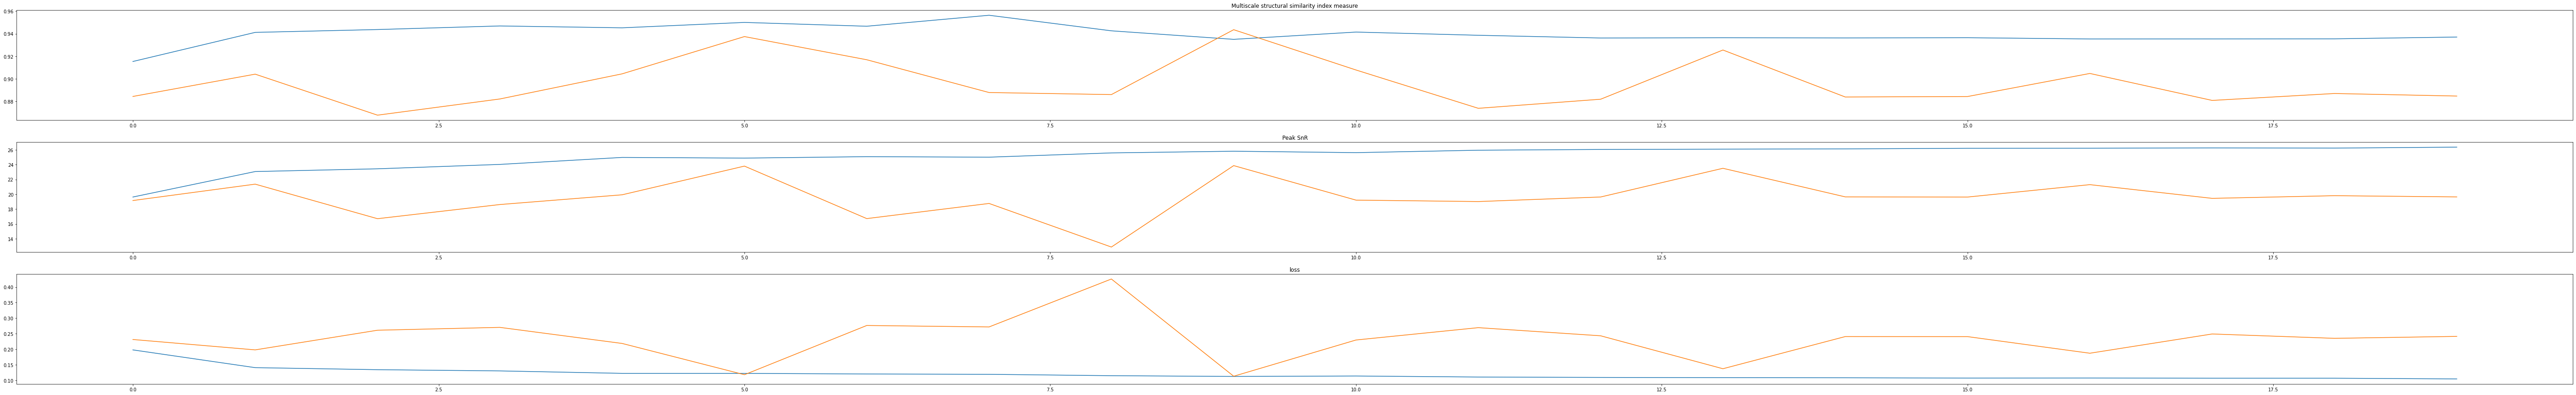

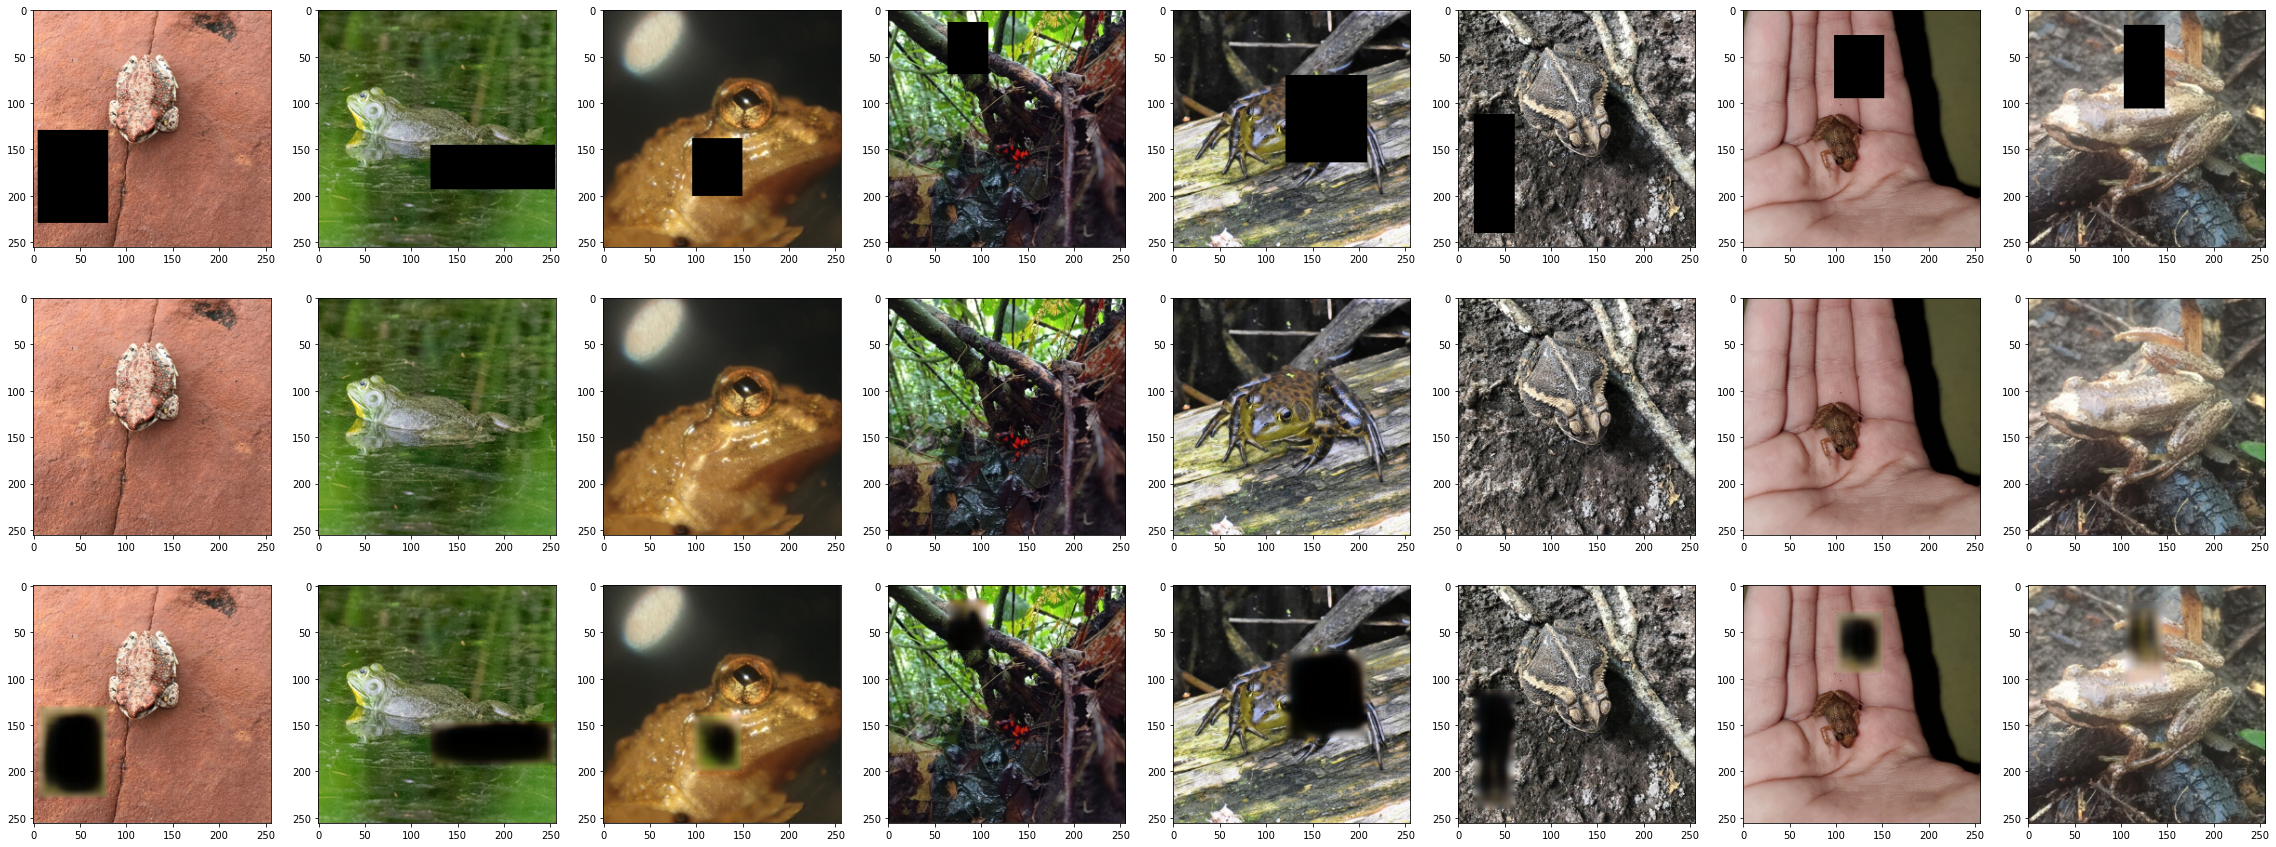

In [17]:
visualize_results(model, device, running_train_results, running_eval_results, test_dataset = validation_dataset)